In [32]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [33]:
# Load the csv data
df = pd.read_csv('data/AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600


In [34]:
# Separate & convert dates to datatime objects for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(10))

10824   2023-11-17
10825   2023-11-20
10826   2023-11-21
10827   2023-11-22
10828   2023-11-24
10829   2023-11-27
10830   2023-11-28
10831   2023-11-29
10832   2023-11-30
10833   2023-12-01
Name: Date, dtype: datetime64[ns]


In [100]:
# Extract the variables for training
data_cols = df[['Open', 'Close','Adj Close']]
training_df = data_cols.astype(float)
training_df

,Open,Close,Adj Close
0,0.128348,0.128348,0.099319
1,0.122210,0.121652,0.094137
2,0.113281,0.112723,0.087228
3,0.115513,0.115513,0.089387
4,0.118862,0.118862,0.091978
...,...,...,...
10829,189.919998,189.789993,189.789993
10830,189.779999,190.399994,190.399994
10831,190.899994,189.369995,189.369995
10832,189.839996,189.949997,189.949997


In [101]:
scaler = StandardScaler()
scaler = scaler.fit(training_df)
scaled_data_df = scaler.transform(training_df)

In [107]:
trainX, trainY = [], [] # Sets containing data used for prediction and the predicted values

n_future = 1 # Number of days we want to predict future values
n_past = 5 # Number of previous days we use to predict future values

# Transform the data into its corresponding sets for the LSTM model
for i in range(n_past, len(scaled_data_df) - n_future +1):
    trainX.append(scaled_data_df[i - n_past:i, 0:training_df.shape[1]])
    trainY.append(scaled_data_df[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY) # Convert to numpy arrays

print(f"TrainX data shape: {trainX.shape}")
print(f"TrainY data shape: {trainY.shape}")


TrainX data shape: (10829, 5, 3)
TrainY data shape: (10829, 1)


In [108]:
# Define the Autoencoder model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='sgd', loss='mse')
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 5, 64)             17408     
                                                                 
 lstm_35 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 (116.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0072 - val_loss: 0.5976
Epoch 2/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0070 - val_loss: 0.4540
Epoch 3/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0065 - val_loss: 0.3725
Epoch 4/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.2531
Epoch 5/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.2114
Epoch 6/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.1296
Epoch 7/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 0.1065
Epoch 8/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.1081
Epoch 9/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0924
Epoch 10/10
305/305 [==============================] - 1s 3ms/step - loss: 0.0055 - val_loss: 0.0830

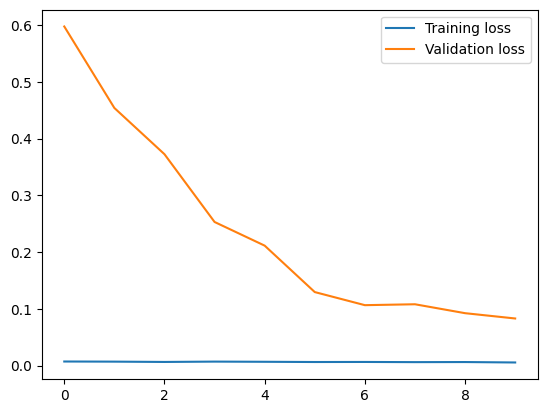

In [110]:
# Fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [111]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Extract the business days in the US only for predicting
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 16
n_days_for_prediction = 15  # Predict for the past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

# Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:])

# Convert into the proper shape by copying the predict data 5x to perform inverse transform and retrive actual values
prediction_copies = np.repeat(prediction, training_df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

1/1 [==============================] - 1s 1s/step


<Axes: xlabel='Date', ylabel='Open'>

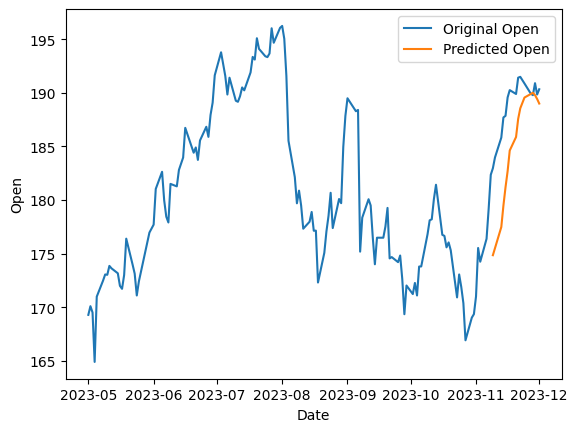

In [112]:
# Convert timestamp to date
forecast_dates = [time_i.date() for time_i in predict_period_dates]

forecast_df = pd.DataFrame({'Date': np.array(forecast_dates), 'Predicted Open': y_pred_future})
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

original = df[['Date', 'Open']].copy()
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-05-01']

plot_data = pd.concat([original[['Date', 'Open']], forecast_df[['Date', 'Predicted Open']]])

# Create a line plot using the concatenated data
sns.lineplot(x='Date', y='Open', data=plot_data, label='Original Open')
sns.lineplot(x='Date', y='Predicted Open', data=plot_data, label='Predicted Open')